In [3]:
!pip install xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 449.7 kB/s eta 0:00:0000:0100:08


In [6]:
#to read the dataset 
# Import packages
import pandas as pd
import numpy as np
# Training and test set creation
def import_data():
    data=pd.read_csv('/root/endToend_lakehouse_deltalake/norway_new_car_sales.csv')
    #combine the "Year" and "Month" columns to create a new "Period" column
    data['Period']=data['Year'].astype(str) + "-" +data['Month'].astype(str)
    #convert to a datetime format 
    data['Period']=pd.to_datetime(data['Period']).dt.strftime("%Y-%m")
    df=pd.pivot_table(data=data,values='Quantity',index='Make',columns='Period',aggfunc='sum',fill_value=0)
    return df

df=import_data()

In [8]:
#dislay the table after manipulation 
print(df)

Period        2007-01  2007-02  2007-03  2007-04  2007-05  2007-06  2007-07  \
Make                                                                          
Alfa Romeo         16        9       21       20       17       21       14   
Aston Martin        0        0        1        0        4        3        3   
Audi              599      498      682      556      630      498      562   
BMW               352      335      365      360      431      477      403   
Bentley             0        0        0        0        0        1        0   
...               ...      ...      ...      ...      ...      ...      ...   
Think               2        0        0        1        0        0        0   
Toyota           2884     1885     1833     1300     1866     1620     1901   
Volkswagen       2521     1517     1428     1257     1934     1531     1777   
Volvo             693      570      656      587      805      662     1064   
Westfield           0        0        0        0    

In [18]:
# Splitting data into train,test and holdout sets
def datasets(df,x_len=12,y_len=1,y_test_len=12,holdout=0):
    D=df.values
    periods=D.shape[1]
    
    #training set creation: run through all the possible time windows
    loops=periods + 1 - x_len - y_len - y_test_len
    train=[]
    for col in range(loops):
        train.append(D[:,col:col+x_len+y_len])
    train=np.vstack(train)
    X_train,Y_train= np.split(train,[x_len],axis=1)
    
    rows=df.shape[0]
    if holdout>0 :
        X_train,X_holdout=np.split(X_train,[-rows*holdout],axis=0)
        Y_train,Y_holdout=np.split(Y_train,[-rows*holdout],axis=0)
    else:
        X_holdout=np.array([])
        Y_holdout=np.array([])
    
    #test set creation:unseen 'future' data with the demand just before
    max_col_test=periods -x_len -y_len +1
    test=[]
    for col in range(loops,max_col_test):
        test.append(D[:,col:col+x_len+y_len])
    test=np.vstack(test)
    X_test,Y_test=np.split(test,[x_len],axis=1)
    
    #this data formatting is needed if we only predict a single period
    if y_len==1:
        Y_train=Y_train.ravel()
        Y_test=Y_test.ravel()
        Y_holdout=Y_holdout.ravel()
    
    return X_train,Y_train,X_holdout,Y_holdout,X_test,Y_test

In [19]:
X_train,Y_train,X_holdout,Y_holdout, X_test,Y_test=datasets(df,holdout=12)

In [4]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

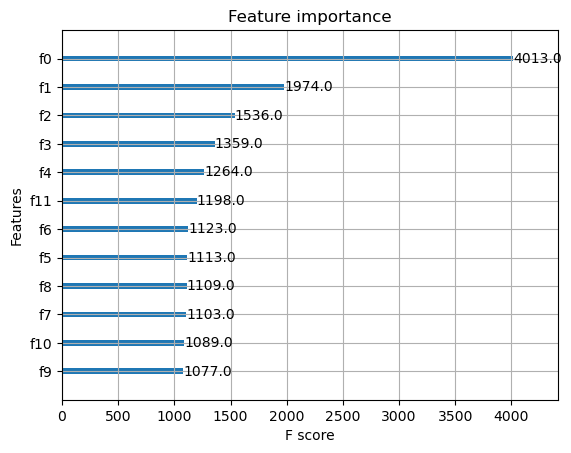

In [21]:
XGB=XGBRegressor(n_jobs=-1,max_depth=10,n_estimators=100,learning_rate=0.2)
XGB=XGB.fit(X_train,Y_train)
# visualize the importance of each feature in the trained model
xgb_plot=xgb.plot_importance(XGB)


In [22]:
# Early Stopping if no improvement is observed on the evaluation set after a certain number of rounds
#optimal number of boosting rounds for the model
x_train,x_eval,y_train,y_eval=train_test_split(X_train,Y_train,test_size=0.15)
XGB=XGBRegressor(n_jobs=-1,max_depth=10,n_estimators=1000,learning_rate=0.2)
XGB=XGB.fit(x_train,y_train,early_stopping_rounds=10,verbose=True,eval_set=[(x_eval,y_eval)],eval_metric='mae')

[0]	validation_0-mae:129.50559
[1]	validation_0-mae:104.46351
[2]	validation_0-mae:84.87404


/root/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/root/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:69.74754
[4]	validation_0-mae:58.18516
[5]	validation_0-mae:49.46446
[6]	validation_0-mae:42.86964
[7]	validation_0-mae:38.34913
[8]	validation_0-mae:35.36764
[9]	validation_0-mae:33.12025
[10]	validation_0-mae:31.54287
[11]	validation_0-mae:30.36473
[12]	validation_0-mae:29.53663
[13]	validation_0-mae:29.08892
[14]	validation_0-mae:28.92558
[15]	validation_0-mae:28.81701
[16]	validation_0-mae:28.64331
[17]	validation_0-mae:28.64507
[18]	validation_0-mae:28.63484
[19]	validation_0-mae:28.62069
[20]	validation_0-mae:28.66324
[21]	validation_0-mae:28.58012
[22]	validation_0-mae:28.60384
[23]	validation_0-mae:28.66722
[24]	validation_0-mae:28.70374
[25]	validation_0-mae:28.75172
[26]	validation_0-mae:28.77758
[27]	validation_0-mae:28.77468
[28]	validation_0-mae:28.81433
[29]	validation_0-mae:28.82385
[30]	validation_0-mae:28.82313
[31]	validation_0-mae:28.89149


In [24]:
#try on the model on the test dataset without the optimized number of rounds 
# Use the trained model to predict on the test set
y_pred = XGB.predict(X_test)
print (y_pred)


[2.01300836e+00 1.75461650e-01 5.85440063e+02 8.70712463e+02
 1.23032629e-01 1.23032629e-01 1.23032629e-01 1.58843249e-01
 1.75461650e-01 1.23032629e-01 1.88998184e+02 6.51143074e+00
 4.54913902e+00 1.23032629e-01 1.23032629e-01 1.58843249e-01
 1.96648045e+01 1.23032629e-01 7.48879578e+02 1.39994293e+02
 2.02100494e+02 1.23032629e-01 1.23032629e-01 1.23032629e-01
 1.42371731e+01 8.83198547e+00 4.19269806e+02 1.23032629e-01
 1.23032629e-01 1.75461650e-01 5.10768547e+01 1.06296150e+02
 1.23032629e-01 7.90799866e+01 1.23032629e-01 3.24804753e-01
 5.62599792e+02 1.23032629e-01 6.47021240e+02 1.23032629e-01
 4.32632721e+02 1.75461650e-01 9.19148982e-01 5.36753601e+02
 2.41039124e+02 5.19839539e+02 1.58527958e+00 4.57863312e+01
 2.60560883e+02 1.23032629e-01 1.75622180e-01 1.23032629e-01
 6.09523132e+02 1.07683687e+01 2.12358689e+00 2.29474838e+02
 2.50568497e+02 1.23032629e-01 1.23032629e-01 1.75619263e+02
 1.23032629e-01 1.20186987e+03 1.34428430e+03 6.12307312e+02
 1.23032629e-01 2.565067

In [26]:
print (Y_test)

[   2    0  531  899    0    0    0    0    0    0  164   14   21    0
    0    0    5    0  754  151  121    0    0    0    5    4  389    0
    0    0   40   95    0   50    0    2  651    0  625    0  607    0
    0  842  274  428    0   34  111    0    0    0  753   11    8   99
  269    0    0  113    0 1374 2044  732    0    3    2  543  933    0
    0    0    0    0    0  155   37   24    0    0    0   17    0  717
  182  159    0    0    0   19    8  367    0    0    0   33   74    0
   55    0    0  550    0  817    0  825    0    2 1105  279  405    0
   30  453    0    0    0  662    6    5  169  292    0    0  487    0
 1537 2236  687    0    3    0  685 1052    0    0    0    0    0    0
  146   49   28    0    0    0   14    0  715  186  212    0    0    0
   18    4  376    0    0    0   32   71    0   53    0    0  564    0
  661    0  630    0    0  782  352  483    0   49  325    0    0    0
  785   11    6  279  252    0    0   96    0 1432 3017  748    0    1
    0 

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate mean squared error
mse = mean_squared_error(Y_test, y_pred)

# Calculate mean absolute error
mae = mean_absolute_error(Y_test, y_pred)

# Calculate R-squared score
r2 = r2_score(Y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


Mean Squared Error: 17965.295577319168
Mean Absolute Error: 46.45651069537569
R-squared: 0.8874234066493399


In [29]:
#try the model on test dataset using the optimized number of rounds : 31 
# Retrain the model with the optimal number of rounds
XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=31, learning_rate=0.2)
XGB = XGB.fit(X_train, Y_train)

# Use the trained model to predict on the test set
y_pred = XGB.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(Y_test, y_pred)

# Calculate mean absolute error
mae = mean_absolute_error(Y_test, y_pred)

# Calculate R-squared score
r2 = r2_score(Y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


Mean Squared Error: 16103.044507915656
Mean Absolute Error: 45.69693778266127
R-squared: 0.8990928991135633


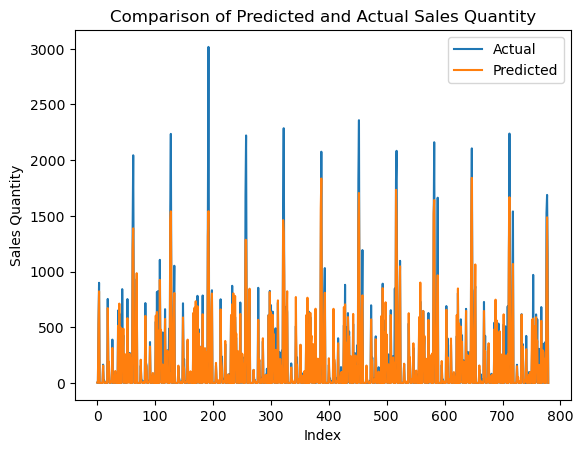

In [31]:
#visulize difference between real values and predicted values test
import matplotlib.pyplot as plt

# Plotting the predicted and actual values
plt.plot(Y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Sales Quantity')
plt.title('Comparison of Predicted and Actual Sales Quantity')
plt.legend()
plt.show()


In [32]:
#further optimization 
# Parameter Optimization: Boosting with Randomized Search
params={'max_depth':[4,5,6,7,8,10,12],
        'learning_rate':[0.001,0.05,0.01,0.025,0.05,0.1],
        'colsample_bylevel':[0.3,0.4,0.6,0.7,0.8,0.9],
        'subsample':[0.2,0.3,0.4,0.5,0.6,0.7],
        'n_estimators':[1000]}

fit_params={'early_stopping_rounds':5,
            'eval_set':[(X_holdout,Y_holdout)],
            'eval_metric':'mae',
            'verbose':False}

XGB=XGBRegressor()
XGB_cv=RandomizedSearchCV(XGB,params,cv=5,n_jobs=-1,verbose=1,n_iter=1000,scoring='neg_mean_absolute_error')
XGB_cv.fit(X_train,Y_train,**fit_params)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


/root/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/root/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/root/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/root/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/roo

KeyboardInterrupt: 

In [ ]:
# Run a new model with full training set 
X_train,Y_train,X_holdout,Y_holdout,X_test,Y_test=datasets(df,holdout=0)
#split to test too 
x_train,x_eval,y_train,y_eval=train_test_split(X_train,Y_train,test_size=0.15)

XGB=XGBRegressor(n_jobs=-1,max_depth=8,n_estimators=1000,learning_rate=0.01,subsample=0.3,colsample_bylevel= 0.5)
XGB=XGB.fit(x_train,y_train,early_stopping_rounds=10,verbose=False,eval_set=[(x_eval,y_eval)],eval_metric='mae')
#MAE_train=np.mean(abs(y_train- XGB ))/np.mean(y_train)
#print('XGBoost on full training set MAE%:',round(MAE_train*100,1))

#fit the model to full X_train using the XGB_cv with optimized params 
Y_train_pred=XGB_cv.fit(X_train)
MAE_train=np.mean(abs(Y_train-Y_train_pred))/np.mean(Y_train)
print('XGBoost on training set MAE%:',round(MAE_train*100,1))
#test model on test dataset 
Y_test_pred=XGB_cv.fit(X_test)
MAE_test=np.mean(abs(Y_test-Y_test_pred))/np.mean(Y_test)
print('XGBoost on test set MAE%:',round(MAE_test*100,1))

In [34]:
#perform XGBoost regression on datasets with single or multiple target variables
def XGBoost(X_train,Y_train,X_test,params):
    #from sklearn.model_selection import train_test_split
    x_train,x_eval,y_train,y_eval=train_test_split(X_train,Y_train,test_size=0.15)
    
    fit_params={'early_stopping_rounds':5,
            'eval_set':[(x_eval,y_eval)],
            'eval_metric':'mae',
            'verbose':False}
    
    XGB=XGBRegressor(**params)
    XGB=XGB.fit(x_train,y_train,**fit_params)
    
    return XGB.predict(X_train),XGB.predict(X_test)

def XGBoost_multi(X_train,Y_train,X_test,params):
    
    Y_train_pred=Y_train.copy()
    Y_test_pred=Y_test.copy()
    
    for col in range(Y_train.shape[1]):
        results=XGBoost(X_train,Y_train[:,col],X_test,params)
        Y_test_pred[:,col]=results[0]
        Y_test_pred[:,col]=results[1]
    
    return Y_test_pred,Y_train_pred


Predicted values for the training set:


NameError: name 'Y_train_pred' is not defined